<a href="https://colab.research.google.com/github/mahikabhartari/BA820-Project-News-Article-Text-Analysis/blob/main/smaller_sample_clustering_sahasra.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

In [2]:

import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import Word2Vec

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
df1 = pd.read_csv('/content/drive/MyDrive/BA820_Project/one_percent_dataset_unclean.csv')

In [5]:
#printing head of the dataframe
df1.head()

,date,year,month,day,author,title,article,url,section,publication,random,rowcnt
0,2017-09-01,2017,9,1,WIRED Staff,The Physics of a 200 MPH Hyperloop Test Run,"The hyperloop, Elon Musk's idea to make a high...",https://www.wired.com/story/hyperloop-200-mph-...,science,Wired,00f01d7b-33d8-4e92-8638-880773fbf1d7,78
1,2018-03-01,2018,3,1,WIRED Staff,"In the US v. Microsoft Supreme Court Case, an ...","On Tuesday, the Supreme Court heard oral argum...",https://www.wired.com/story/us-v-microsoft-sup...,security,Wired,016bf2aa-5f77-4c75-8be1-f9495949f4c0,123
2,2016-07-01,2016,7,1,WIRED Staff,NASA Confirms New Horizons Is Hurtling Towards...,"Remember how excited you were last summer? No,...",https://www.wired.com/2016/07/nasa-confirms-ne...,science,Wired,017edd40-66cf-40b0-a22e-6f15d024533e,128
3,2016-04-01,2016,4,1,WIRED Staff,Eye in the Sky Is the Quintessential Modern Wa...,The war film is one of cinema's most enduring ...,https://www.wired.com/2016/04/eye-in-the-sky-m...,culture,Wired,01a4c8dd-8ba5-457e-b5ae-11c9c1360f75,146
4,2019-04-01,2019,4,1,Emily Flake,"Blended Family, Hollywood Edition",Moments after putting the finishing touches on...,https://www.newyorker.com/magazine/2019/04/01/...,magazine,New Yorker,001f4a18-4e30-41ff-90a4-52454684758e,1


In [6]:
# number of rows and columns
df1.shape

(26751, 12)

In [7]:
#seeing the datatypes
df1.dtypes

date           object
year            int64
month           int64
day             int64
author         object
title          object
article        object
url            object
section        object
publication    object
random         object
rowcnt          int64
dtype: object

In [8]:
#checking for null values
df1.isna().sum()

date               0
year               0
month              0
day                0
author         10022
title              0
article          897
url                0
section         8961
publication        0
random             0
rowcnt             0
dtype: int64

In [9]:
#dropping null values from the og dataframe
df1.dropna(subset=['article'], inplace=True)

In [10]:
df1.duplicated()

0        False
1        False
2        False
3        False
4        False
         ...  
26746    False
26747    False
26748    False
26749    False
26750    False
Length: 25854, dtype: bool

In [11]:
df1.duplicated().value_counts()

False    25854
dtype: int64

In [12]:
#number of duplicates in url
df1.duplicated(subset=['url']).sum()

0

In [13]:
#number of duplicates in title
df1.duplicated(subset=['title']).sum()

73

In [14]:
# checking for duplicates in the "title" column (sanity check)
duplicate_titles = df1[df1.duplicated(subset=['title'], keep=False)]
duplicate_titles

,date,year,month,day,author,title,article,url,section,publication,random,rowcnt
262,2017-10-01 11:10:01,2017,10,1,Sam Sifton,What to Cook This Week,What to Cook Sam Sifton emails readers of Cook...,https://www.nytimes.com/2017/10/01/dining/what...,dining,The New York Times,007e63a3-2a40-4345-a80e-f89429ebeee9,444
946,2018-02-02 00:00:00,2018,2,2,Tiernan Morgan,Art Movements,This week in art news: a trucker drove across ...,https://hyperallergic.com/424236/art-movements...,NaN,Hyperallergic,007ce1a9-2bc5-4227-8096-a5ee20e44bfb,26
948,2018-03-02 00:00:00,2018,3,2,Tiernan Morgan,Art Movements,This week in art news: a mafia member revealed...,https://hyperallergic.com/429538/art-movements...,NaN,Hyperallergic,013e6b00-881a-4678-81a4-a74d3d7f33e4,75
1066,2016-03-02 00:58:33,2016,3,2,NaN,Quotation of the Day,"“You step in there, and it’s like you’re not e...",http://www.nytimes.com/2016/03/02/todayspaper/...,todayspaper,The New York Times,0095ffad-3549-4734-963f-4c1c3ba0d6e2,531
1812,2017-11-03 14:45:00,2017,11,3,VICE Staff,The VICE Morning Bulletin,Everything you need to know about the world th...,https://www.vice.com/en_us/article/59y59x/the-...,The VICE Morning Bulletin,Vice,002732e0-10a5-47ab-9a33-21d213ce1ccd,53
...,...,...,...,...,...,...,...,...,...,...,...,...
25587,2017-07-30 00:00:00,2017,7,30,Hrag Vartanian,Required Reading,"This week, discussing ICA Boston’s new Schutz ...",https://hyperallergic.com/393185/required-read...,NaN,Hyperallergic,01e13158-3dbf-45a1-81b3-16d48890dc23,109
26062,2019-09-30 00:00:00,2019,9,30,Alex Gangitano,Bottom Line | TheHill,"HEALTH CARE. Intact Vascular, Inc., a manufact...",https://thehill.com/business-a-lobbying/lobbyi...,NaN,The Hill,00f30d39-7dff-4a01-8edf-bac1c92c29ac,791
26415,2017-01-31 20:59:19,2017,1,31,NaN,Quotation of the Day,“America’s enemies feared it for dealing in fa...,https://www.nytimes.com/2017/01/31/todayspaper...,todayspaper,The New York Times,01da741a-36ba-4798-8b17-fba1cddf11c5,1755
26472,2019-07-31,2019,7,31,NaN,Directors of Australia's Crown Resorts attack ...,(Reuters) - Casino operator Crown Resorts (CWN...,https://www.reuters.com/article/australia-crow...,World News,Reuters,00a7ed8f-c711-4a85-ba0d-e50a48f51f81,2232


In [15]:
#counting occurrences of each duplicate title
duplicate_titles_only = duplicate_titles['title']
duplicate_titles_only.value_counts()

Deals of the day-Mergers and acquisitions                                                 5
French and Benelux stocks-Factors to watch                                                4
Quotation of the Day                                                                      4
Required Reading                                                                          4
Politics this week                                                                        4
The VICE Morning Bulletin                                                                 3
The Hill's 12:30 Report | TheHill                                                         3
The Mail                                                                                  3
EU must focus on avoiding cliff-edge in Brexit talks - senior EU official                 2
Tu resumen de noticias del jueves                                                         2
Tuesday Morning Briefing                                                        

In [16]:
#checking duplicates for articles as the same titled articles could belong to different timeline
df1.duplicated(subset=['article']).sum()


115

In [17]:
#dropping duplicates
df1.drop_duplicates(subset=['article'], inplace=True)

In [18]:
#printing unique number of authors, sections, publications, year
df1['author'].unique()

array(['WIRED Staff', 'Emily Flake', 'Editorial Board', ...,
       'By Brooke Brower, Ross Levitt and Wade Payson-Denney, CNN',
       'By Abeer Salman with Andrew Carey, CNN', 'By Devan Cole'],
      dtype=object)

In [19]:
df1['section'].unique()

array(['science', 'security', 'culture', 'magazine', nan, 'College',
       'TERROR', 'Airlines', 'Media Buzz', 'OPINION', 'Jeep', 'asia',
       'the-economist-explains', 'finance-and-economics', 'business',
       'graphic-detail', 'europe', 'britain', 'leaders', 'international',
       'TL;DR', 'Google', 'Reviews', 'Tech', 'Apps', 'Entertainment',
       'Policy', 'Gaming', 'Business', 'Space', 'Fakes', 'Apple',
       'Sploid', 'Health', 'Sports', 'Music by VICE', 'Food by VICE ',
       'Tech by VICE', 'Comment', 'Travel', 'Identity', 'Noisey', 'Money',
       'Islamic State', 'horoscopes', 'News by VICE', 'Astro Guide',
       'nyregion', 'movies', 'sports', 'arts', 'fashion', 'us', 'health',
       'books', 'world', 'podcasts', 'dining', 'travel', 'opinion',
       't-magazine', 'upshot', 'learning', 'technology', 'theater',
       'let-the-voting-begin', 'style', 'obituaries', 'Market News',
       'Westlaw News', 'Business News', 'Communications Equipment',
       'Company New

In [20]:
df1['year'].unique()

array([2017, 2018, 2016, 2019, 2020])

In [21]:
author_value_counts = df1['author'].value_counts()
author_counts_df = author_value_counts.reset_index()
author_counts_df.columns = ['Author', 'Count']
author_counts_df

,Author,Count
0,WIRED Staff,164
1,The Associated Press,80
2,Associated Press,76
3,Field Level Media,69
4,John Bowden,66
...,...,...
6422,Kara Scannell,1
6423,"Michele Gelfand, University of Maryland psycho...",1
6424,Chef Marcus Samuelsson,1
6425,Adrienne So,1


In [22]:
df1['title'].unique()

array(['The Physics of a 200 MPH Hyperloop Test Run',
       'In the US v. Microsoft Supreme Court Case, an Old Law Leaves Few Good Options',
       'NASA Confirms New Horizons Is Hurtling Towards Some Barren Space Rock Named 2014 MU69',
       ...,
       'UPDATE 3-GE posts loss, takes Boeing hit but raises forecast; CFO to leave',
       'Here’s what caught my eye this morning: Trader',
       "Moscow court case challenges city's facial recognition use after launch"],
      dtype=object)

In [23]:
title_value_counts = df1['title'].value_counts()
title_counts_df = title_value_counts.reset_index()
title_counts_df.columns = ['Title', 'Count']
title_counts_df

,Title,Count
0,Deals of the day-Mergers and acquisitions,5
1,French and Benelux stocks-Factors to watch,4
2,Quotation of the Day,4
3,Politics this week,4
4,Required Reading,4
...,...,...
25675,Meet the Guy Selling Wireless Tech to Steal Lu...,1
25676,I'm Not OK: Remembering What It Meant to Be Emo,1
25677,"Daily Horoscopes: June 12, 2019",1
25678,Alabama Governor Resigns Before He Can Be Impe...,1


In [24]:
df1['section'].unique()

array(['science', 'security', 'culture', 'magazine', nan, 'College',
       'TERROR', 'Airlines', 'Media Buzz', 'OPINION', 'Jeep', 'asia',
       'the-economist-explains', 'finance-and-economics', 'business',
       'graphic-detail', 'europe', 'britain', 'leaders', 'international',
       'TL;DR', 'Google', 'Reviews', 'Tech', 'Apps', 'Entertainment',
       'Policy', 'Gaming', 'Business', 'Space', 'Fakes', 'Apple',
       'Sploid', 'Health', 'Sports', 'Music by VICE', 'Food by VICE ',
       'Tech by VICE', 'Comment', 'Travel', 'Identity', 'Noisey', 'Money',
       'Islamic State', 'horoscopes', 'News by VICE', 'Astro Guide',
       'nyregion', 'movies', 'sports', 'arts', 'fashion', 'us', 'health',
       'books', 'world', 'podcasts', 'dining', 'travel', 'opinion',
       't-magazine', 'upshot', 'learning', 'technology', 'theater',
       'let-the-voting-begin', 'style', 'obituaries', 'Market News',
       'Westlaw News', 'Business News', 'Communications Equipment',
       'Company New

In [25]:
section_value_counts = df1['section'].value_counts()
section_counts_df = section_value_counts.reset_index()
section_counts_df.columns = ['Section', 'Count']
section_counts_df

,Section,Count
0,World News,1129
1,Business News,1030
2,Market News,1005
3,Wires,665
4,politics,547
...,...,...
635,Children's Health,1
636,news,1
637,the-world-if,1
638,educators-against-intolerance,1


In [26]:
df1['publication'].unique()

array(['Wired', 'New Yorker', 'Washington Post', 'Vice News', 'TMZ',
       'New Republic', 'Fox News', 'Axios', 'Economist', 'Refinery 29',
       'Buzzfeed News', 'The Verge', 'Gizmodo', 'Hyperallergic',
       'TechCrunch', 'Mashable', 'Vice', 'Vox', 'Business Insider',
       'The New York Times', 'Reuters', 'People', 'Politico', 'The Hill',
       'CNN', 'CNBC'], dtype=object)

In [27]:
publication_value_counts = df1['publication'].value_counts()
publication_counts_df = publication_value_counts.reset_index()
publication_counts_df.columns = ['Publication', 'Count']
publication_counts_df

,Publication,Count
0,Reuters,8241
1,The New York Times,2489
2,CNBC,2342
3,The Hill,2021
4,People,1344
5,CNN,1249
6,Vice,1009
7,Mashable,941
8,Refinery 29,871
9,Business Insider,579


FURTHER ANALYSIS OF THE DATA

In [28]:
#groupping by authors to see the number of articles written by them
articles_by_publication = df1.groupby('publication').size().reset_index(name='num_articles')

#calculating the average word count per article for each author
avg_word_count = df1.groupby('publication')['article'].apply(lambda x: x.str.split().str.len().mean()).reset_index(name='avg_word_count')

#merging the two dataframes
publication_contribution = pd.merge(articles_by_publication, avg_word_count, on='publication')


In [29]:
#publication v/s articles
publication_contribution_sorted = publication_contribution.sort_values(by='num_articles', ascending=False)
publication_contribution_sorted


,publication,num_articles,avg_word_count
15,Reuters,8241,291.059095
19,The New York Times,2489,909.824829
3,CNBC,2342,471.595645
18,The Hill,2021,580.356754
12,People,1344,429.875000
4,CNN,1249,686.902322
21,Vice,1009,782.782953
9,Mashable,941,432.552604
14,Refinery 29,871,492.091848
1,Business Insider,579,801.982729


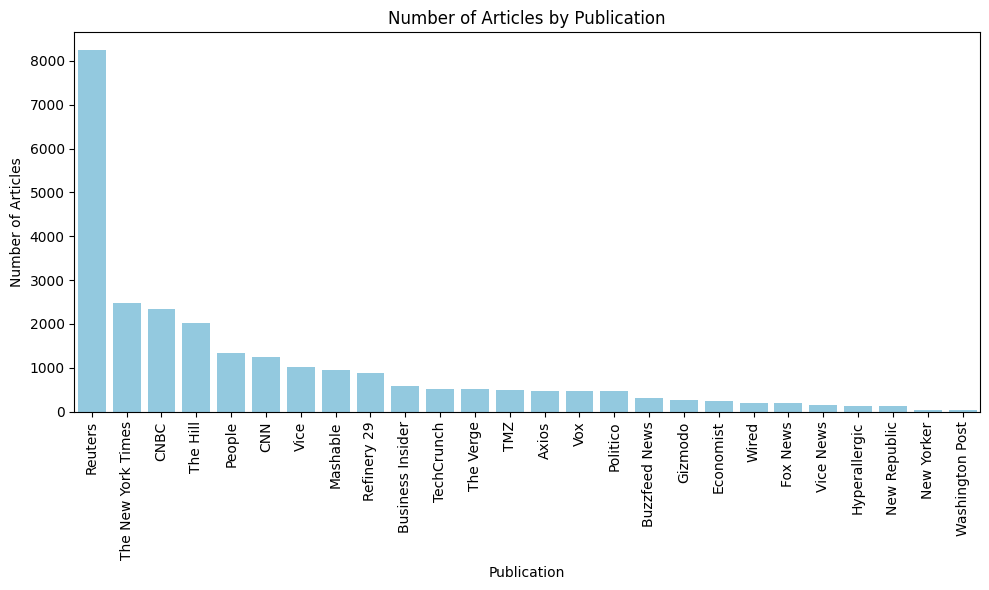

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

#bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x='publication', y= 'num_articles', data= publication_contribution_sorted, color= 'skyblue')
plt.title('Number of Articles by Publication')
plt.xlabel('Publication')
plt.ylabel('Number of Articles')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [31]:
#publication vs avg word count
publication_avgword_sorted = publication_contribution.sort_values(by='avg_word_count', ascending=False)
publication_avgword_sorted

,publication,num_articles,avg_word_count
11,New Yorker,47,2243.319149
23,Vox,471,1050.235669
8,Hyperallergic,134,924.746269
19,The New York Times,2489,909.824829
2,Buzzfeed News,318,842.820755
10,New Republic,118,823.881356
22,Vice News,155,813.406452
1,Business Insider,579,801.982729
21,Vice,1009,782.782953
5,Economist,238,779.554622


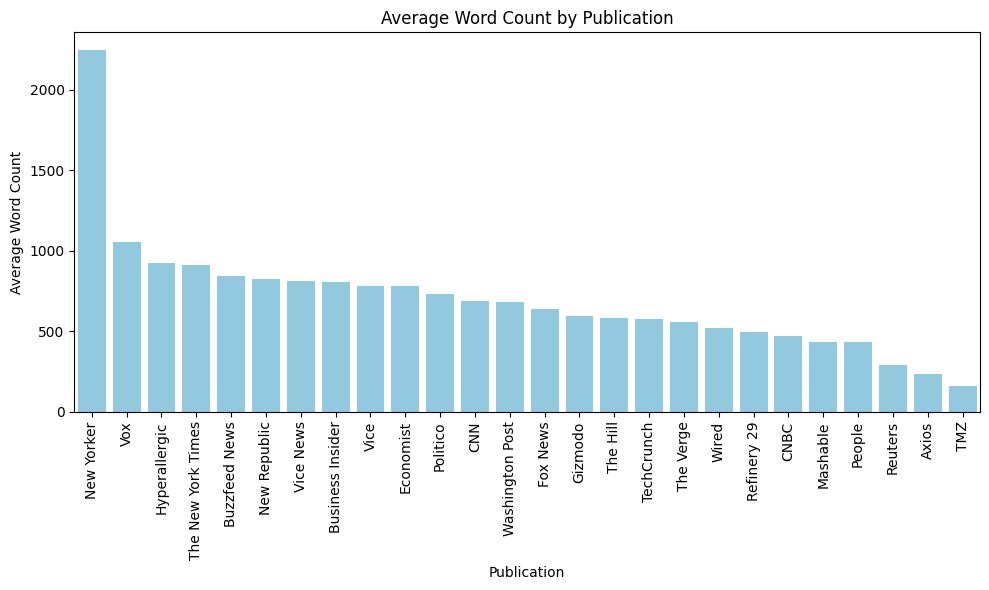

In [32]:
# publication vs avg word count
plt.figure(figsize=(10, 6))
sns.barplot( x= 'publication', y='avg_word_count', data= publication_avgword_sorted, color= 'skyblue')
plt.title('Average Word Count by Publication')
plt.xlabel('Publication')
plt.ylabel('Average Word Count')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [33]:
#groupping by 'section' and count the number of articles in each section
section_distribution = df1.groupby('section').size().reset_index(name='num_articles')

#sorting sections by the number of articles in descending order
section_distribution_sorted = section_distribution.sort_values(by='num_articles', ascending=False)
top_10_sections = section_distribution_sorted.head(10)
top_10_sections

,section,num_articles
471,World News,1129
65,Business News,1030
264,Market News,1005
468,Wires,665
585,politics,547
168,Financials,543
628,us,527
233,Intel,401
326,Politics,336
58,Bonds News,312


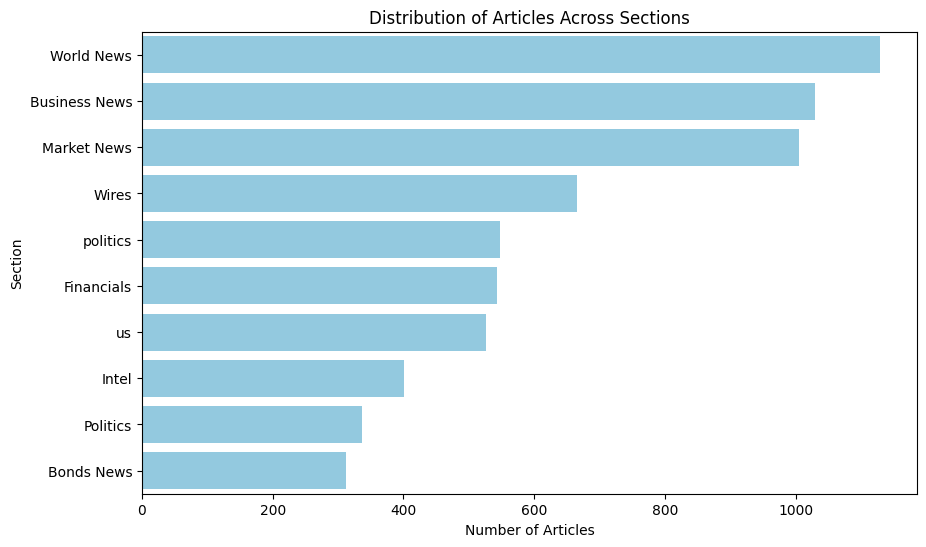

In [34]:
import seaborn as sns
#plotting distribution of articles across sections
plt.figure(figsize=(10, 6))
sns.barplot(x='num_articles', y='section', data=top_10_sections, color= 'skyblue')
plt.title('Distribution of Articles Across Sections')
plt.xlabel('Number of Articles')
plt.ylabel('Section')
plt.show()

In [35]:
#time series

#extracting year from 'date' column
#df['year'] = df['date'].dt.year

#groupping by 'year' and count the number of articles for each year
articles_by_year = df1.groupby('year').size()

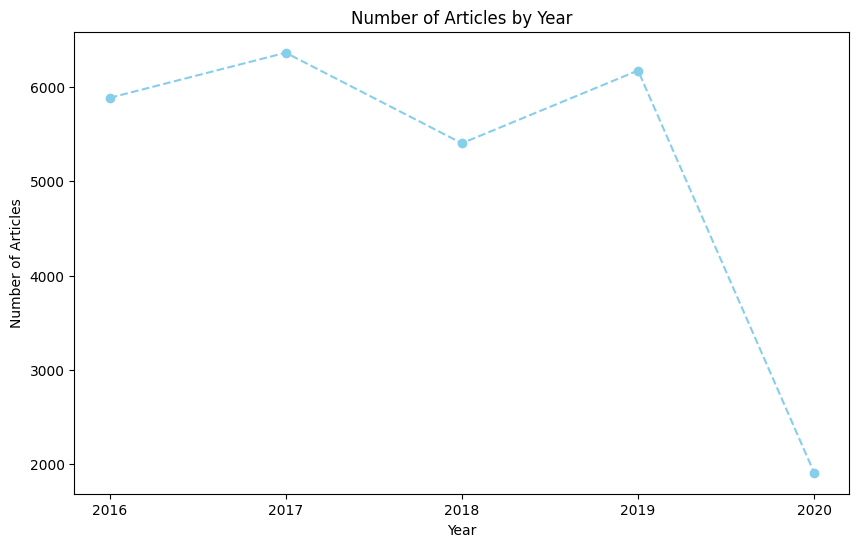

In [36]:
# plotting line chart
plt.figure(figsize=(10, 6))
plt.plot(articles_by_year.index.astype(int), articles_by_year.values, color='skyblue', marker='o', linestyle='--')
plt.title('Number of Articles by Year')
plt.xlabel('Year')
plt.ylabel('Number of Articles')
plt.xticks(articles_by_year.index.astype(int))  # Set x-axis ticks to be whole years

plt.show()

In [37]:
#word cloud
from collections import Counter
nltk.download('punkt')
title_tokens = [word for title in df1['title'] for word in word_tokenize(title.lower())]
title_word_freq = Counter(title_tokens)

title_word_freq.most_common(10)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


[('to', 7199),
 (',', 5634),
 ('in', 4563),
 ('the', 4448),
 (':', 4155),
 ('of', 3921),
 ("'s", 3846),
 ('for', 3233),
 ('a', 2924),
 ('on', 2773)]

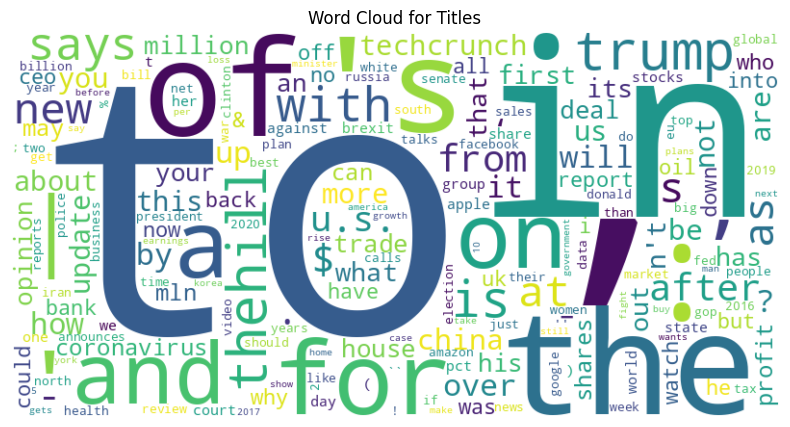

In [38]:
from wordcloud import WordCloud


title_wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(title_word_freq)
plt.figure(figsize=(10, 5))
plt.imshow(title_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Titles')
plt.show()

In [39]:
#taking a subset of articles because of the huge volume of words
df1_subset = df1.head(9000)

article_tokens = [word for article in df1_subset['article'] for word in word_tokenize(article.lower())]
article_word_freq = Counter(article_tokens)

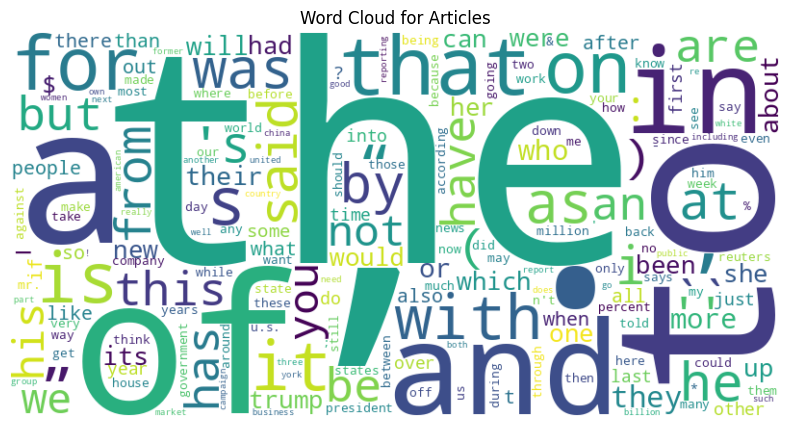

In [40]:
article_wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(article_word_freq)
plt.figure(figsize=(10, 5))
plt.imshow(article_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Articles')
plt.show()

In [41]:
#importing cleaned dataframe
df1.to_csv('/content/drive/MyDrive/BA820_Project/cleaned_data_final.csv')

In [50]:
df = pd.read_csv('/content/drive/MyDrive/BA820_Project/cleaned_data_final.csv')

In [51]:
df.publication.value_counts(normalize =True).mul(100).round(2).astype(str) + '%'

Reuters               32.02%
The New York Times     9.67%
CNBC                    9.1%
The Hill               7.85%
People                 5.22%
CNN                    4.85%
Vice                   3.92%
Mashable               3.66%
Refinery 29            3.38%
Business Insider       2.25%
TechCrunch             2.02%
The Verge               2.0%
TMZ                    1.91%
Axios                  1.83%
Vox                    1.83%
Politico               1.79%
Buzzfeed News          1.24%
Gizmodo                1.06%
Economist              0.92%
Wired                  0.78%
Fox News               0.78%
Vice News               0.6%
Hyperallergic          0.52%
New Republic           0.46%
New Yorker             0.18%
Washington Post        0.14%
Name: publication, dtype: object

In [52]:
mdf = pd.read_html('https://components.one/datasets/all-the-news-2-news-articles-dataset')
mdf = mdf[1]
mdf

,Publication,Count
0,Axios,47815
1,Business Insider,57953
2,Buzzfeed News,32819
3,CNBC,238096
4,CNN,127602
5,Economist,26227
6,Fox News,20144
7,Gizmodo,27228
8,Hyperallergic,13551
9,Mashable,94107


In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25739 entries, 0 to 25738
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Unnamed: 0   25739 non-null  int64 
 1   date         25739 non-null  object
 2   year         25739 non-null  int64 
 3   month        25739 non-null  int64 
 4   day          25739 non-null  int64 
 5   author       16546 non-null  object
 6   title        25739 non-null  object
 7   article      25739 non-null  object
 8   url          25739 non-null  object
 9   section      17543 non-null  object
 10  publication  25739 non-null  object
 11  random       25739 non-null  object
 12  rowcnt       25739 non-null  int64 
dtypes: int64(5), object(8)
memory usage: 2.6+ MB


In [54]:
df.article = df.article.str.lower()
df.title = df.title.str.lower()
df['article'] = df['article'].fillna('')
df.article = df.article.str.replace('/^(https?:\/\/)?([\da-z\.-]+)\.([a-z\.]{2,6})([\/\w \.-]*)*\/?$/','',regex=True) #find and drop hyperlinks
df.article = df.article.str.replace('\d+','',regex=True) #numbers
df.article = df.article.str.replace('[^\w\s]','',regex=True) #trailing spaces
df.article = df.article.str.replace('[^a-zA-Z\s]','',regex=True)#non english characters

In [55]:
df

,Unnamed: 0,date,year,month,day,author,title,article,url,section,publication,random,rowcnt
0,0,2017-09-01,2017,9,1,WIRED Staff,the physics of a 200 mph hyperloop test run,the hyperloop elon musks idea to make a highsp...,https://www.wired.com/story/hyperloop-200-mph-...,science,Wired,00f01d7b-33d8-4e92-8638-880773fbf1d7,78
1,1,2018-03-01,2018,3,1,WIRED Staff,"in the us v. microsoft supreme court case, an ...",on tuesday the supreme court heard oral argume...,https://www.wired.com/story/us-v-microsoft-sup...,security,Wired,016bf2aa-5f77-4c75-8be1-f9495949f4c0,123
2,2,2016-07-01,2016,7,1,WIRED Staff,nasa confirms new horizons is hurtling towards...,remember how excited you were last summer no n...,https://www.wired.com/2016/07/nasa-confirms-ne...,science,Wired,017edd40-66cf-40b0-a22e-6f15d024533e,128
3,3,2016-04-01,2016,4,1,WIRED Staff,eye in the sky is the quintessential modern wa...,the war film is one of cinemas most enduring g...,https://www.wired.com/2016/04/eye-in-the-sky-m...,culture,Wired,01a4c8dd-8ba5-457e-b5ae-11c9c1360f75,146
4,4,2019-04-01,2019,4,1,Emily Flake,"blended family, hollywood edition",moments after putting the finishing touches on...,https://www.newyorker.com/magazine/2019/04/01/...,magazine,New Yorker,001f4a18-4e30-41ff-90a4-52454684758e,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
25734,26746,2018-08-31 00:00:00,2018,8,31,NaN,how productive people utilize their time off,labor day can serve as the perfect excuse to s...,https://www.cnbc.com/2018/05/25/how-productive...,NaN,CNBC,0227b6aa-c585-476c-9054-0c3788d68d6a,1980
25735,26747,2017-10-31,2017,10,31,NaN,white house releases official portraits of tru...,the white house on tuesday released the first ...,https://www.cnbc.com/2017/10/31/white-house-re...,Politics,CNBC,022e36e0-5645-4da9-b4fd-43c712751433,2008
25736,26748,2019-07-31,2019,7,31,NaN,"update 3-ge posts loss, takes boeing hit but r...",recasts updates shares july reuters general ...,https://www.cnbc.com/2019/07/31/reuters-americ...,Wires,CNBC,023f8ff5-194c-4e0f-94b5-a8cbd0066fb5,2072
25737,26749,2016-05-31,2016,5,31,NaN,here’s what caught my eye this morning: trader,the potential for higher rates is causing agit...,https://www.cnbc.com/2016/05/31/heres-what-cau...,NaN,CNBC,026bbf22-e263-4b81-a2a5-1b988cace45d,2232


In [56]:
import nltk
from nltk.corpus import words
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import word_tokenize
nltk.download('words')
nltk.download('punkt')
# Create a set for efficiency
english_words = set(words.words())
def english_only(text):
    return [token for token in word_tokenize(text) if token in english_words]

cv = CountVectorizer(tokenizer=english_only, stop_words='english')
dtm = cv.fit_transform(df.article)

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [57]:
len(cv.get_feature_names_out())

33026

In [58]:
print('number of `tokens`', len(cv.vocabulary_))
cv.vocabulary_

number of `tokens` 33026


{'idea': 13624,
 'make': 16765,
 'transit': 29592,
 'people': 20484,
 'exercise': 9827,
 'despite': 7571,
 'roster': 24342,
 'piles': 20883,
 'money': 17890,
 'realizing': 22952,
 'travel': 29649,
 'nearly': 18449,
 'airless': 649,
 'tube': 29913,
 'supersonic': 28028,
 'human': 13416,
 'taken': 28448,
 'ride': 24102,
 'date': 7009,
 'theyre': 28973,
 'case': 4219,
 'musk': 18254,
 'holding': 13150,
 'ongoing': 19377,
 'competition': 5523,
 'student': 27639,
 'build': 3661,
 'test': 28855,
 'weekend': 32291,
 'pod': 21203,
 'clock': 5062,
 'highest': 13047,
 'speed': 26810,
 'built': 3666,
 'campus': 3975,
 'supreme': 28073,
 'court': 6369,
 'oral': 19471,
 'argument': 1488,
 'united': 30845,
 'v': 31506,
 'believe': 2514,
 'significant': 25886,
 'cloud': 5089,
 'technology': 28678,
 'interact': 14668,
 'government': 12073,
 'end': 9248,
 'dispute': 8151,
 'reach': 22911,
 'act': 274,
 'law': 15859,
 'ability': 42,
 'obtain': 19216,
 'second': 25149,
 'circuit': 4847,
 'prominent': 220

In [59]:
vocab = cv.vocabulary_
df_vocab = pd.DataFrame(list(vocab.items()), columns=['word', 'index'])
df_vocab = df_vocab.sort_values(by ='index',ascending=True)

In [60]:
df_vocab

,word,index
10204,aa,0
21898,aal,1
25209,aardvark,2
4862,aba,3
5585,aback,4
...,...,...
11662,zoom,33021
30879,zoonotic,33022
23821,zooplankton,33023
10869,zucchini,33024


In [61]:
from sklearn.feature_extraction.text import TfidfVectorizer
# Create a set for efficienc
english_words = set(words.words())
def english_only(text):
    return [token for token in word_tokenize(text) if token in english_words]

In [62]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from multiprocessing import Pool

nltk.download('stopwords')
nltk.download('words')
nltk.download('wordnet')

# Assuming 'df' is your DataFrame and 'text' is the column you want to process
lemmatizer = WordNetLemmatizer()
english_words = set(nltk.corpus.words.words())
stop_words = set(stopwords.words('english'))

# Create a function to apply to each row in your DataFrame
def process_text(text):
    tokenized_text = word_tokenize(text)
    removed_stopwords = [word for word in tokenized_text if word not in stop_words]
    return ' '.join([lemmatizer.lemmatize(word) for word in removed_stopwords])
with Pool() as pool:
  df['processed_article'] = pool.map(process_text, df['article'])

tfidf_model = TfidfVectorizer(norm=None)
df_tfidf_transformed = tfidf_model.fit_transform(df.processed_article)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [63]:
len(tfidf_model.vocabulary_)

185761

In [64]:
stop_words

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

In [65]:
df_sub = df[['article','processed_article']].head(5)
df_sub

,article,processed_article
0,the hyperloop elon musks idea to make a highsp...,hyperloop elon musk idea make highspeed transi...
1,on tuesday the supreme court heard oral argume...,tuesday supreme court heard oral argument unit...
2,remember how excited you were last summer no n...,remember excited last summer found booth state...
3,the war film is one of cinemas most enduring g...,war film one cinema enduring genre nearly ever...
4,moments after putting the finishing touches on...,moment putting finishing touch landmark billio...


In [66]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
from multiprocessing import Pool
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('words')

# Assuming 'df' is your DataFrame and 'text' is the column you want to process
stemmer = SnowballStemmer('english')
english_words = set(nltk.corpus.words.words())
stop_words = set(stopwords.words('english'))

# Create a function to apply to each row in your DataFrame
def process_text(text):
    return ' '.join([stemmer.stem(word) for word in word_tokenize(text) if word in english_words and word not in stop_words])

with Pool() as pool:
  df['processed_article'] = pool.map(process_text, df['article'])


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [67]:
tfidf_model = TfidfVectorizer()
df_tfidf_transformed = tfidf_model.fit_transform(df.processed_article)

In [68]:
len(tfidf_model.vocabulary_)

23945

In [69]:
min(df_tfidf_transformed.shape)

23945

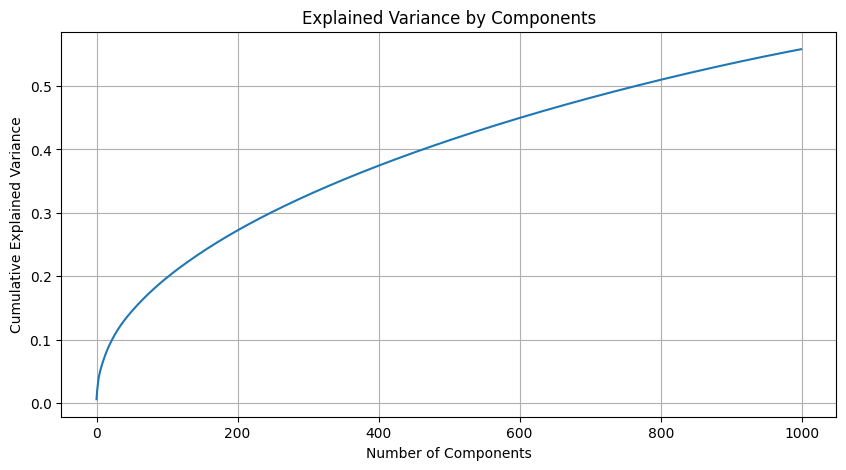

In [70]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=1000)  # or any other number less than min(df_tfidf_transformed.shape)
df_svd_transformed = svd.fit_transform(df_tfidf_transformed)
import matplotlib.pyplot as plt
# Plot the cumulative sum of explained variance ratio
plt.figure(figsize=(10,5))
plt.plot(np.cumsum(svd.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Components')
plt.grid(True)
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

ValueError: x and y must have same first dimension, but have shapes (16,) and (15,)

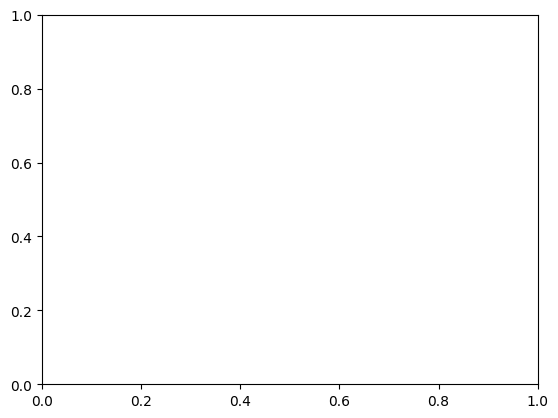

In [72]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
inertia = []
for k in range(5, 20):
  kmeans = KMeans(n_clusters=k, random_state= 42)
  kmeans.fit(df_svd_transformed)
  inertia.append(kmeans.inertia_)



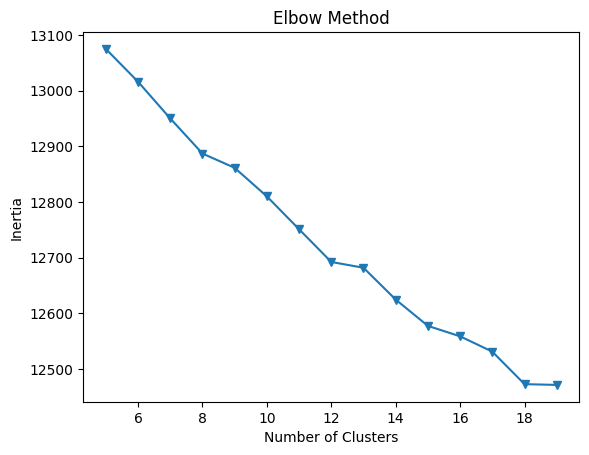

In [73]:
plt.plot(range (5, 20), inertia, marker= 'v')
plt. title('Elbow Method')
plt.xlabel ('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

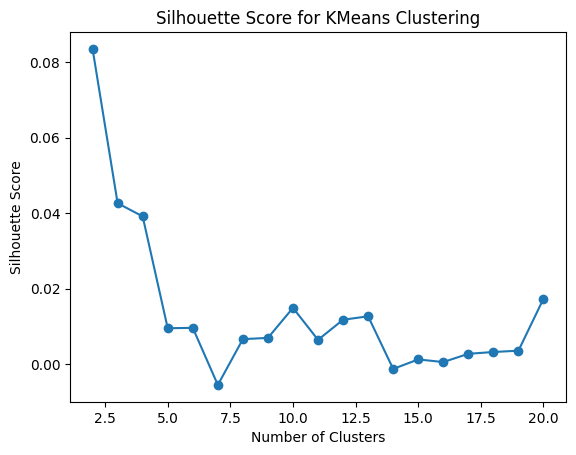

In [74]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

# Initialize a list to store silhouette scores
silhouette_scores = []

# Range of clusters
clusters_range = range(2, 21)  # Adjust the range as per your requirement

# Calculate silhouette score for each value of k
for k in clusters_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_svd_transformed)  # Assuming df_svd_transformed is your data
    labels = kmeans.labels_
    silhouette_scores.append(silhouette_score(df_svd_transformed, labels))

# Plotting silhouette scores
plt.plot(clusters_range, silhouette_scores, marker='o')
plt.title('Silhouette Score for KMeans Clustering')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

In [75]:
from sklearn.cluster import KMeans

# Define the number of clusters
num_clusters = 10  # or any other number based on your specific needs

# Create a KMeans model
kmeans = KMeans(n_clusters=num_clusters)

# Fit the model to your data and predict the cluster labels
labels = kmeans.fit_predict(df_svd_transformed)

# Add the labels to your DataFrame
df['cluster_label'] = labels

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


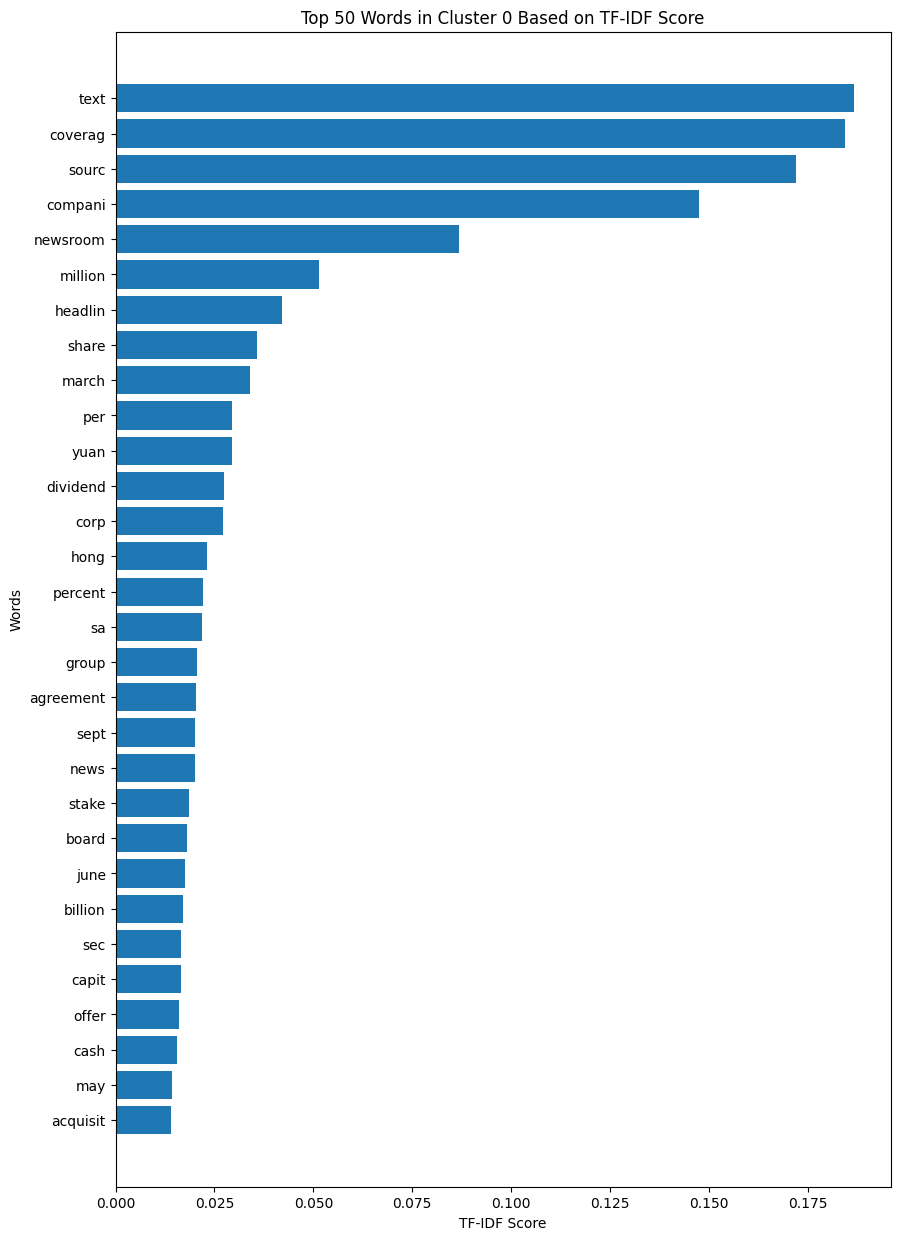

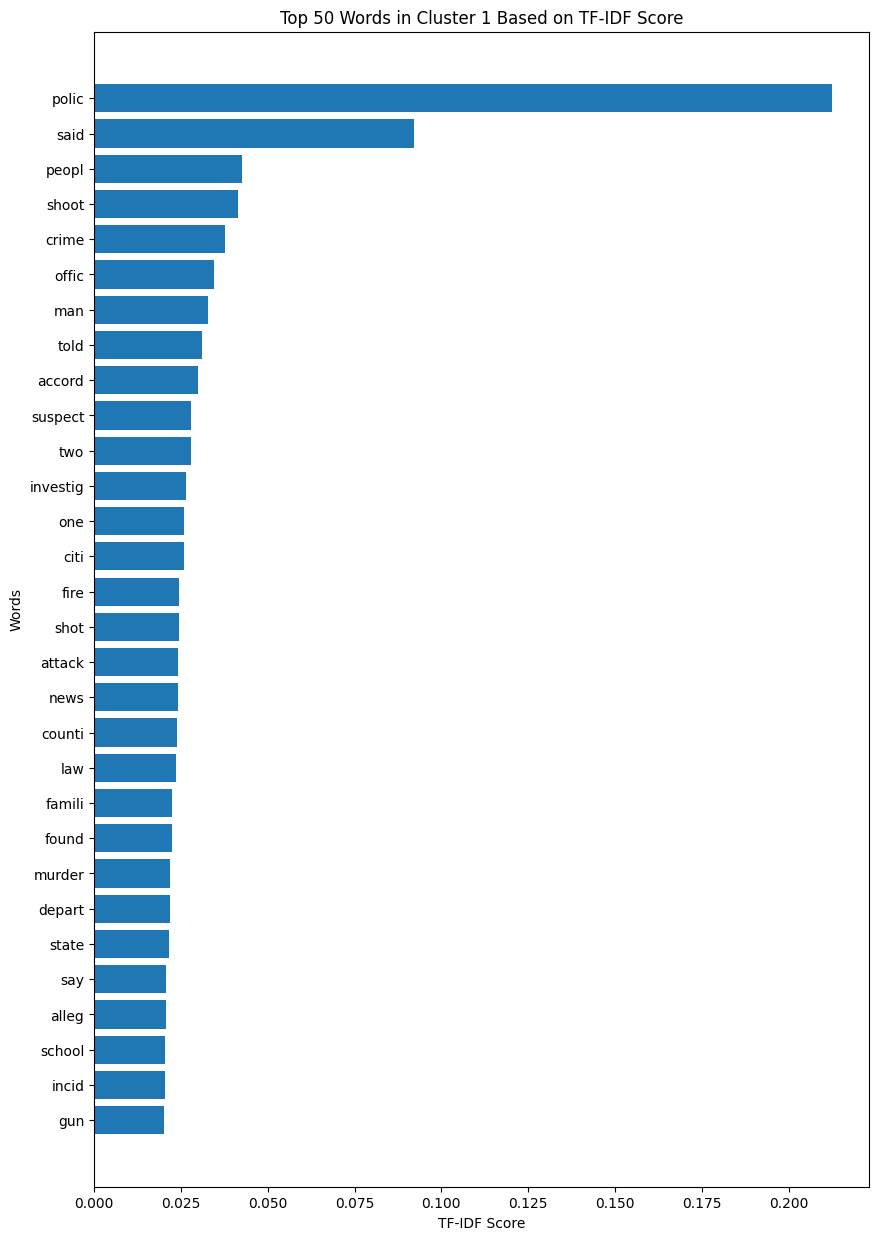

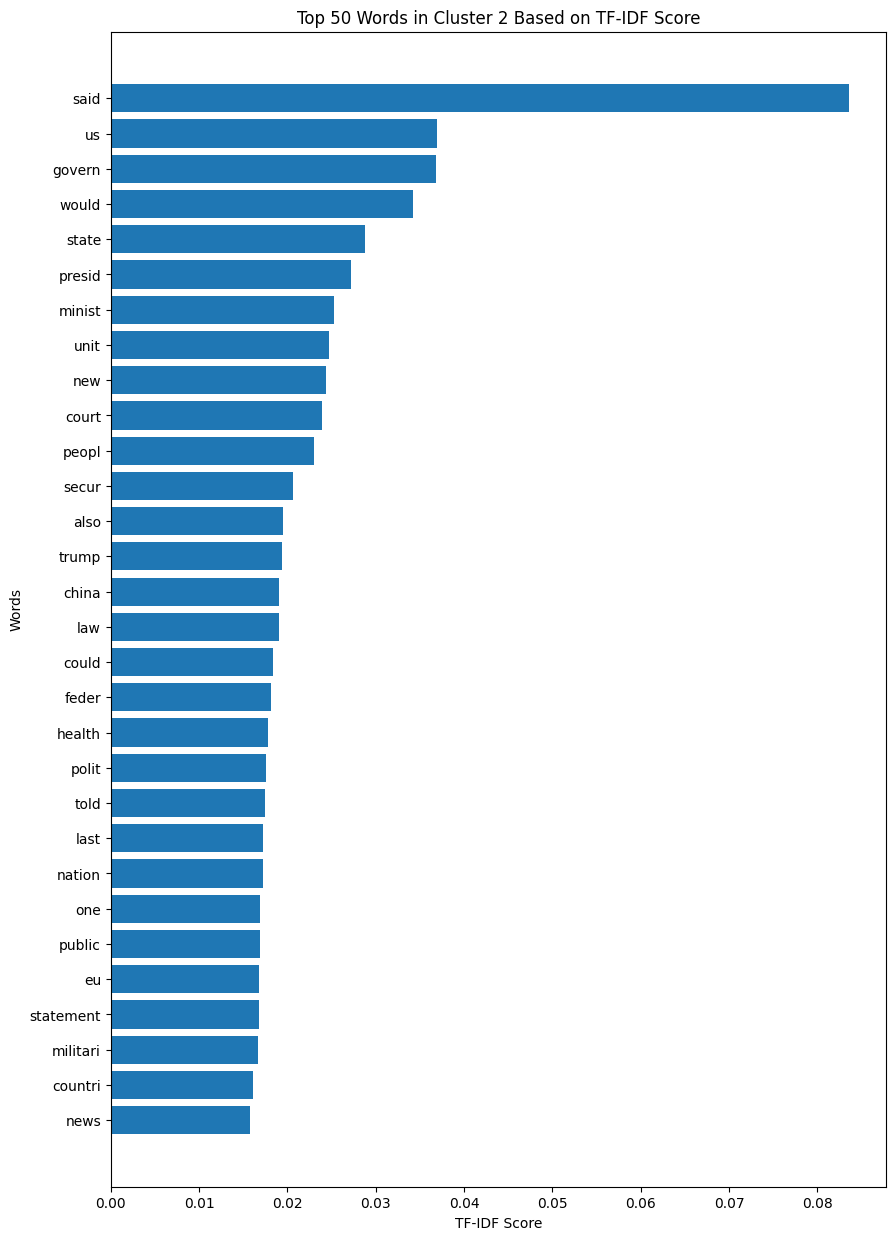

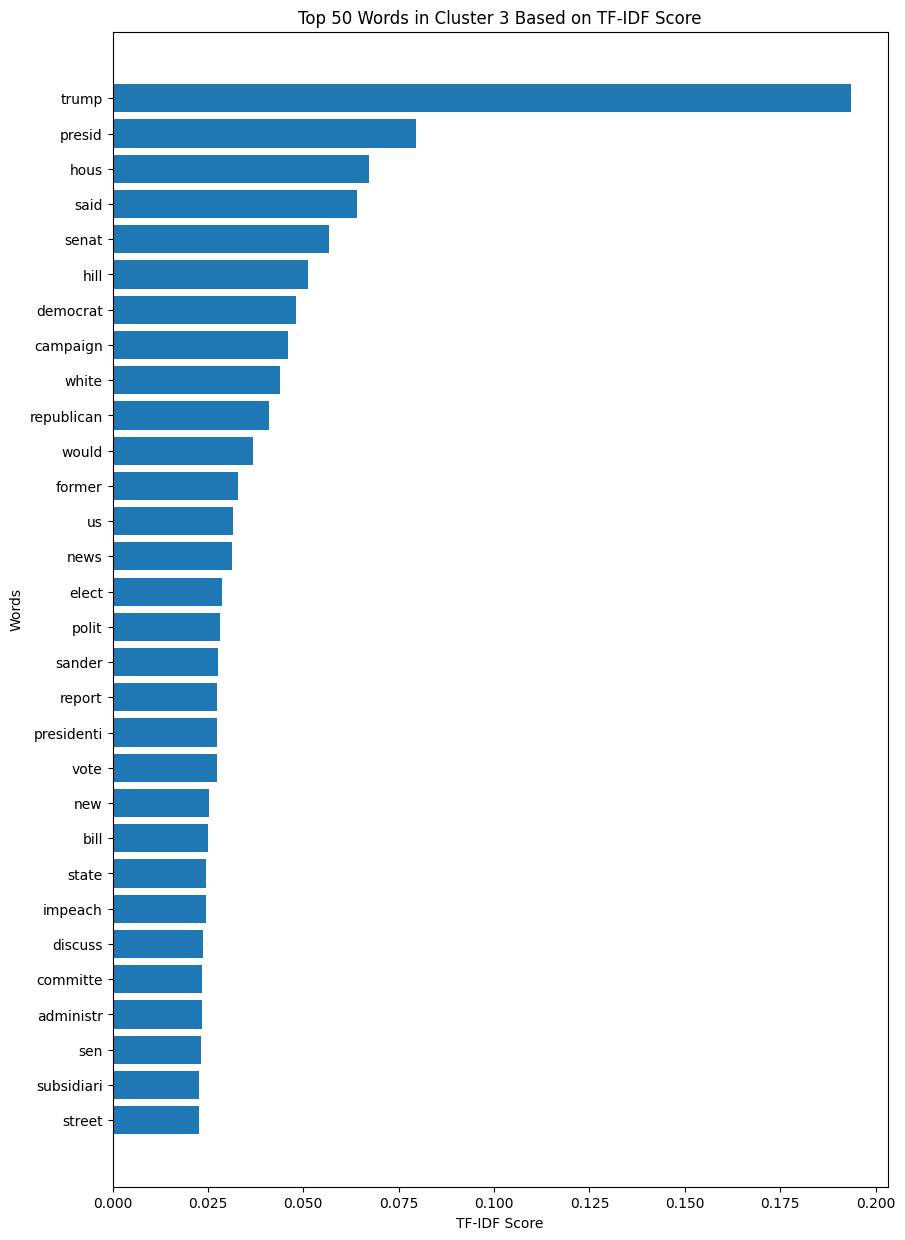

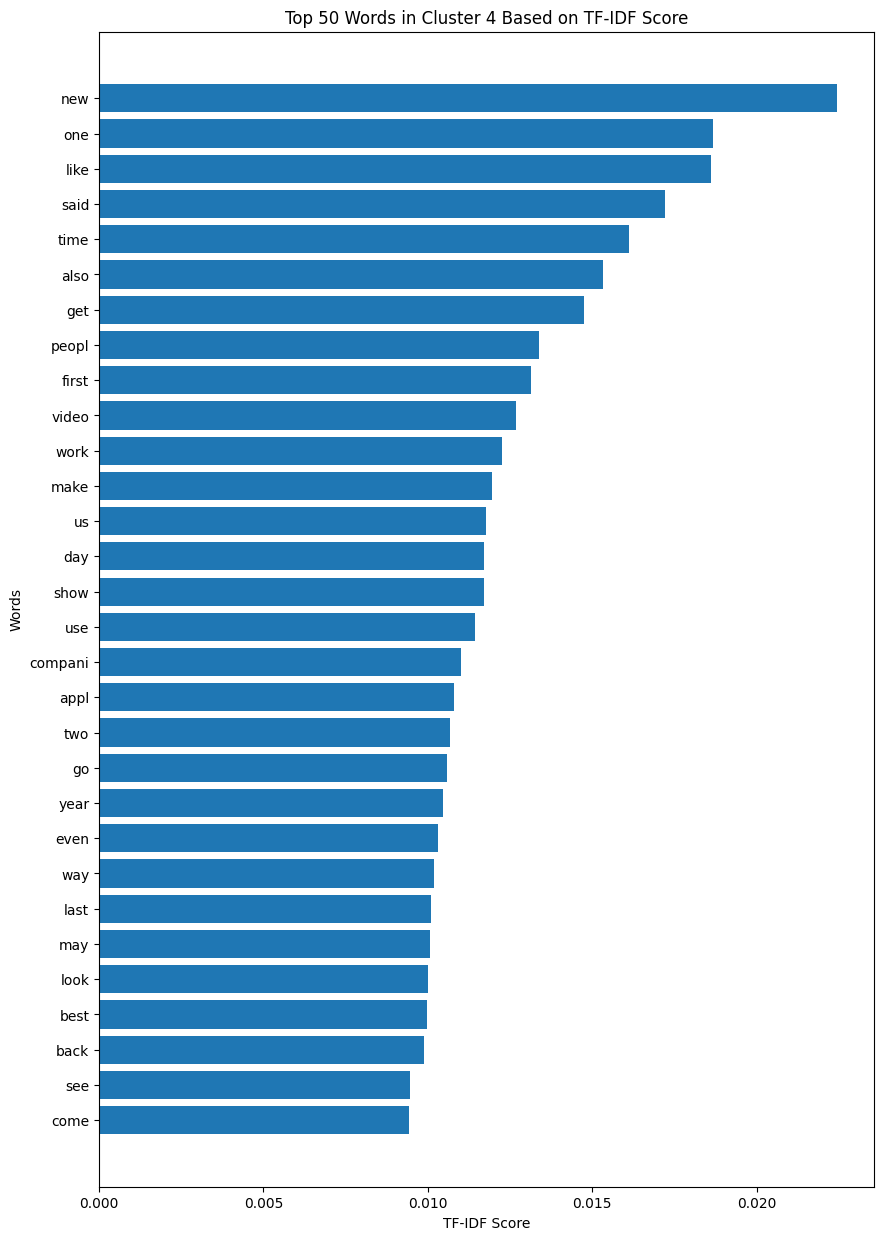

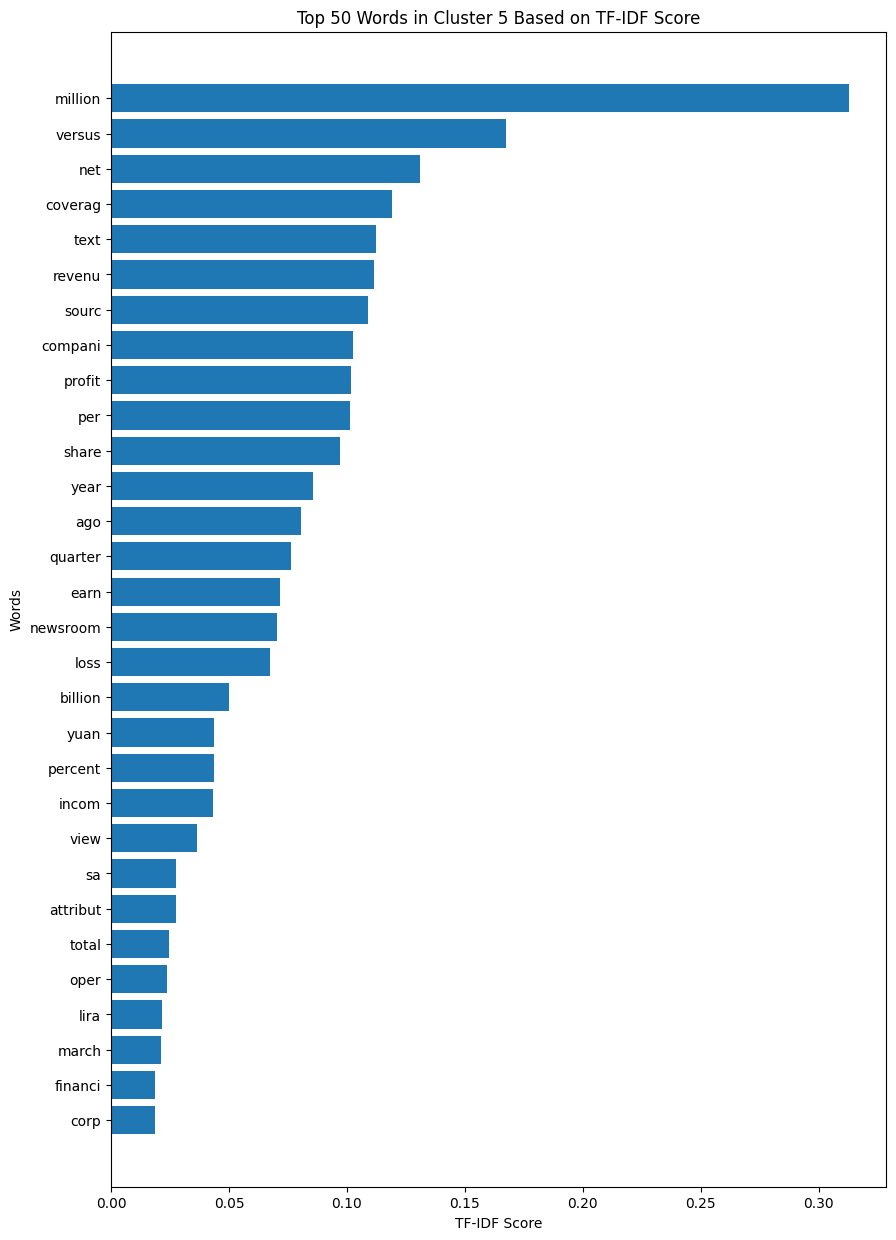

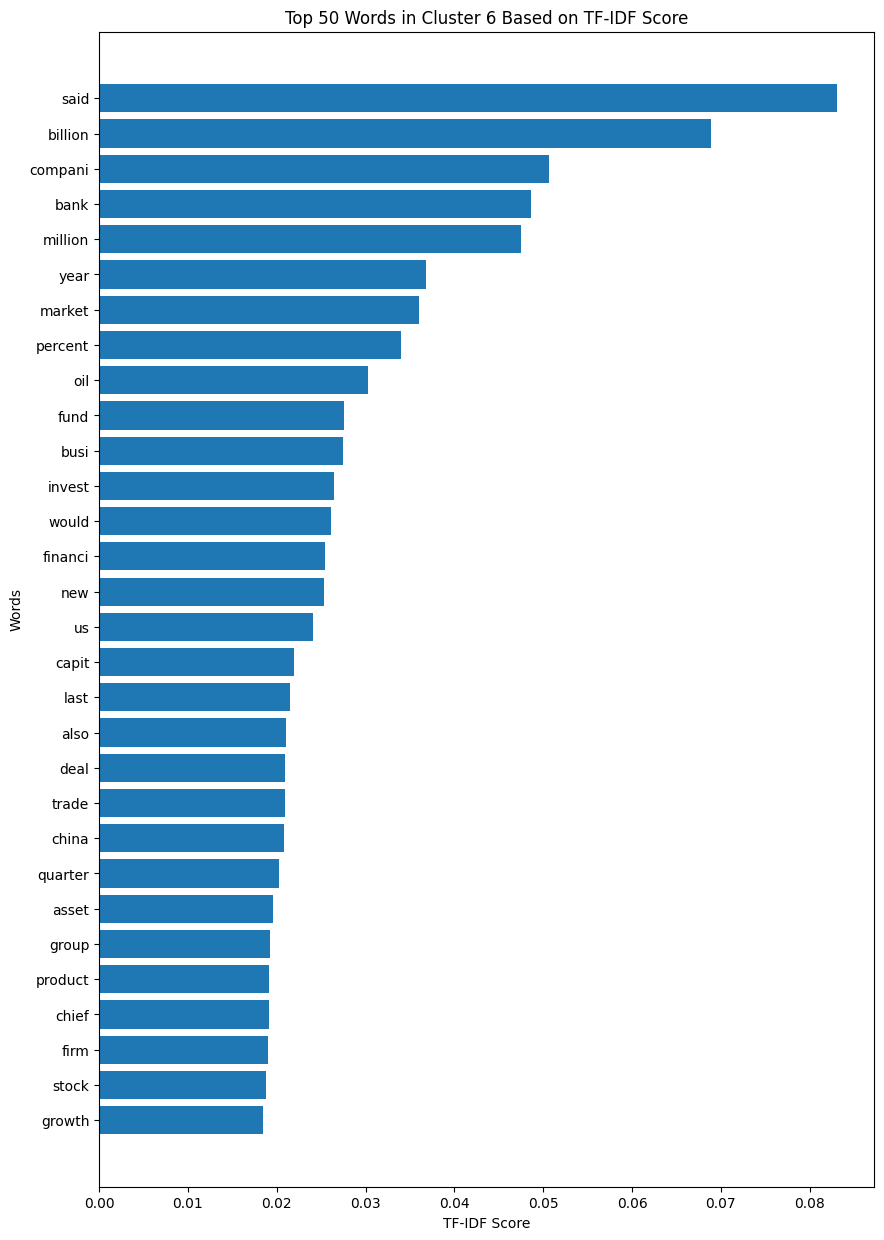

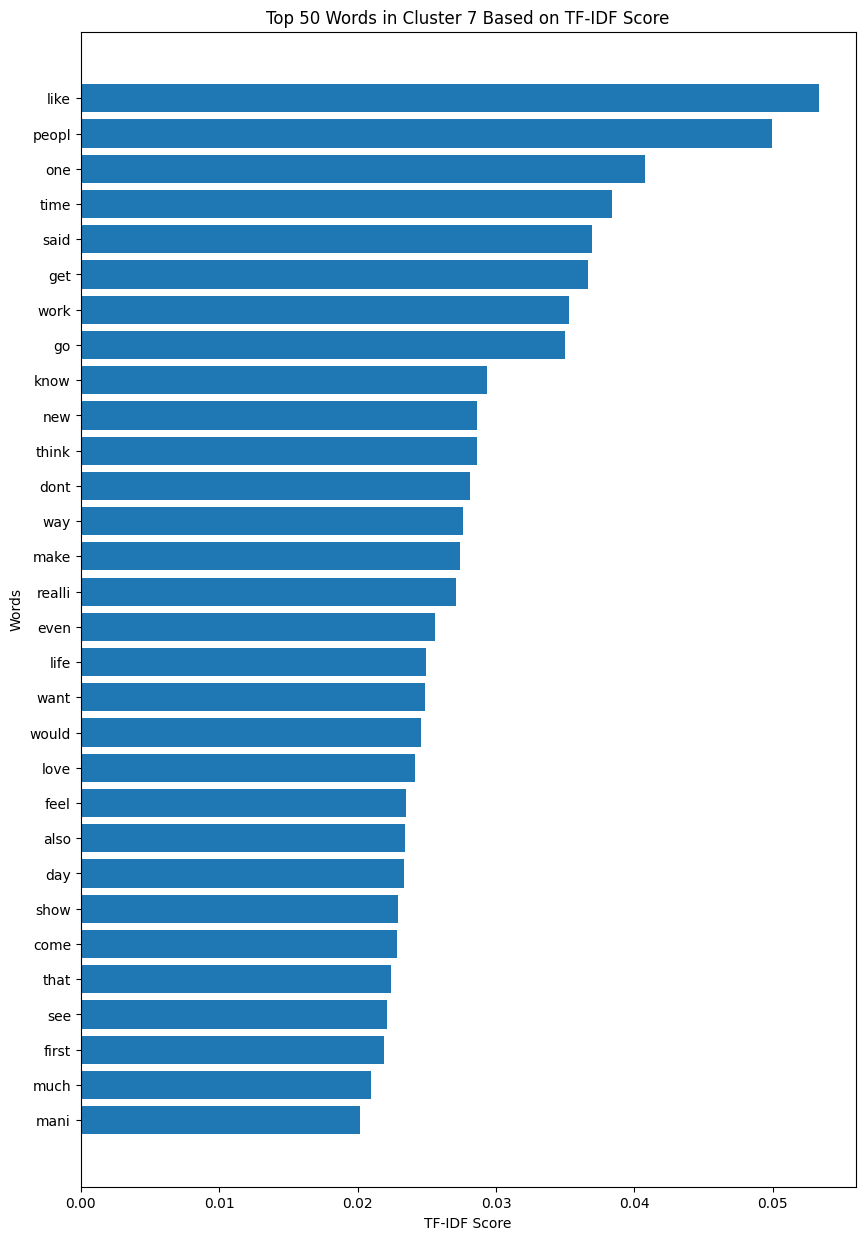

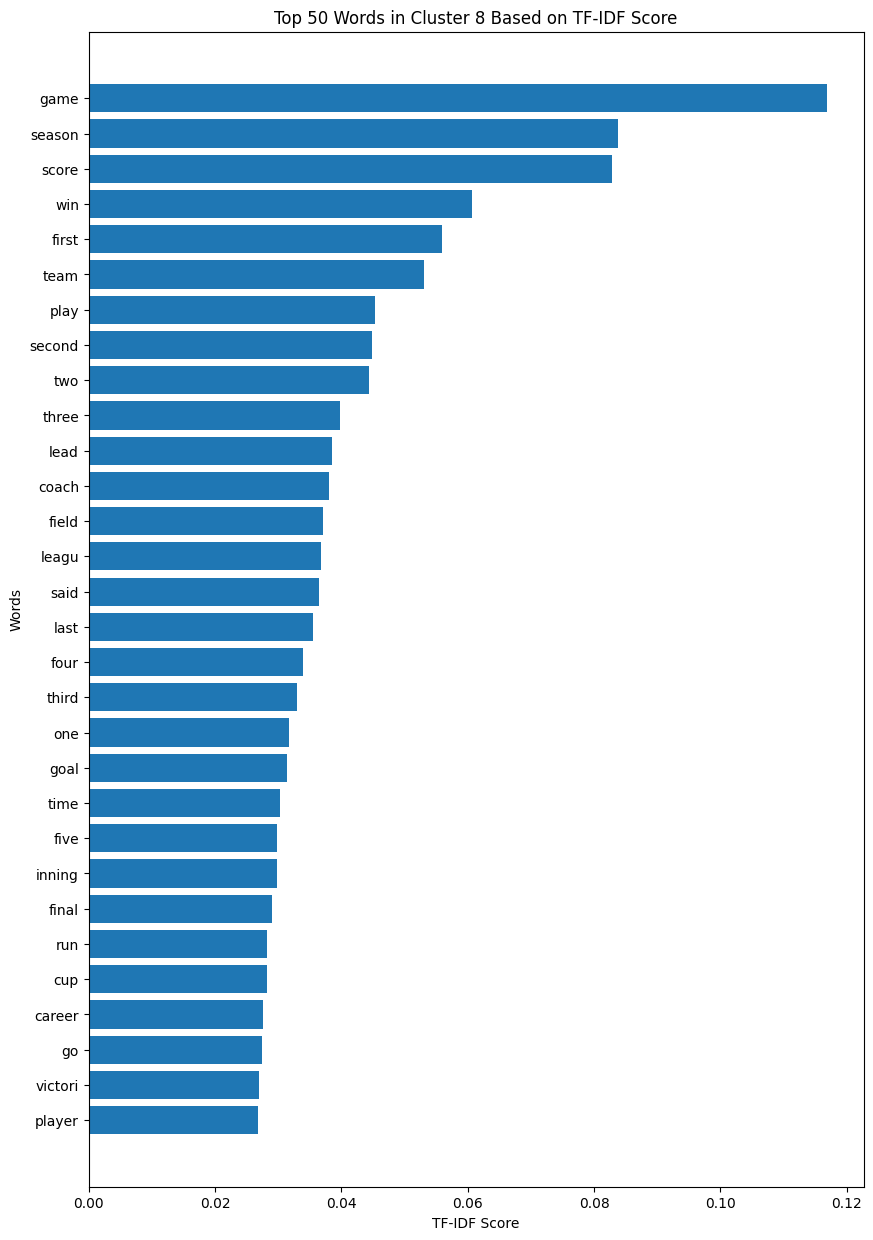

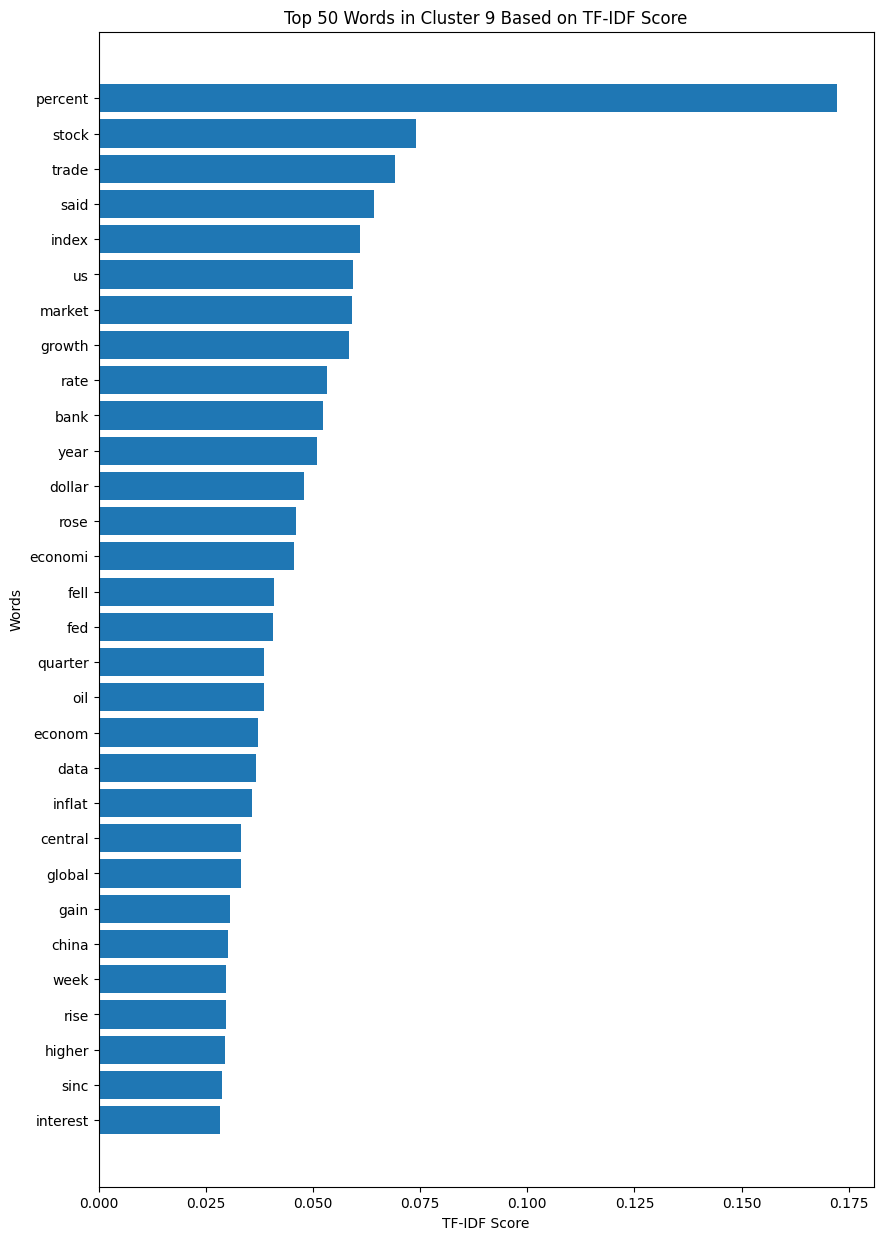

In [76]:
from collections import defaultdict
import matplotlib.pyplot as plt

# Get feature names from the vectorizer
feature_names = tfidf_model.get_feature_names_out()

# Initialize a dictionary to hold the top 50 words for each cluster
top_words_per_cluster = defaultdict(list)

# Get the top 50 words for each cluster
for i in range(num_clusters):
    # Get all items in current cluster
    cluster_items = df_tfidf_transformed[labels == i].toarray()

    # Calculate the mean tf-idf score for each word in the cluster
    mean_tfidf_scores = cluster_items.mean(axis=0)

    # Get the indices of the top 50 scores
    top_indices = np.argsort(mean_tfidf_scores)[::-1][:30]

    # Get the top words and their scores
    top_words = [(feature_names[j], mean_tfidf_scores[j]) for j in top_indices]

    # Add the top words to the dictionary
    top_words_per_cluster[i] = top_words

    # Plot the top 50 words
    plt.figure(figsize=(10, 15))
    plt.barh(*zip(*top_words[::-1]))
    plt.title(f'Top 50 Words in Cluster {i} Based on TF-IDF Score')
    plt.xlabel('TF-IDF Score')
    plt.ylabel('Words')
    plt.show()


In [77]:
#word cloud
from collections import Counter
nltk.download('punkt')
title_tokens = [word for title in df['processed_title'] for word in word_tokenize(title.lower())]
title_word_freq = Counter(title_tokens)

title_word_freq.most_common(10)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


KeyError: 'processed_title'

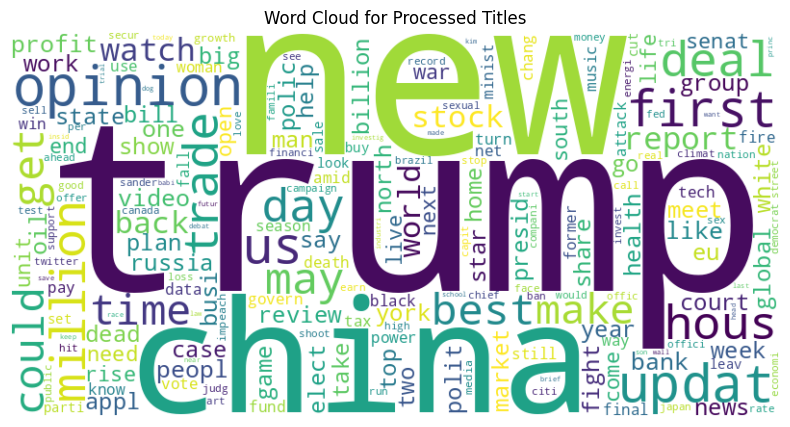

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

title_wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(title_word_freq)
plt.figure(figsize=(10, 5))
plt.imshow(title_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Processed Titles')
plt.show()

In [78]:
#taking a subset of articles because of the huge volume of words
df1_subset = df.head(9000)

article_tokens = [word for article in df1_subset['processed_article'] for word in word_tokenize(article.lower())]
article_word_freq = Counter(article_tokens)

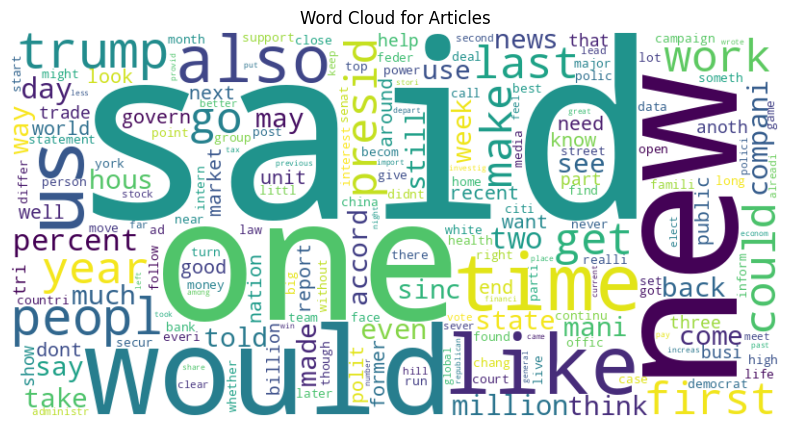

In [79]:
article_wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(article_word_freq)
plt.figure(figsize=(10, 5))
plt.imshow(article_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Articles')
plt.show()

In [ ]:
x = 85753*(100/5)
x

1715060.0